# Code for the paper "Spatial search with multiple marked vertices is optimal for almost all queries and its quantum advantage is not always guaranteed"

In [1]:
# Maths and data management
import math
from math import pi
import numpy as np
import pandas as pd
import pickle

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Fitting curves
from scipy.optimize import curve_fit

# Plotting configuration
%matplotlib inline
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

## 1. Quantum walk implementation
This section's aim is to implement the quantum walk of the paper and simulate it using numpy.

The walk is on a grid of size $2^{nb}\times 2^{nb}$ where $nb$ is the size parameter. Most of the time, we define $N=2^{nb}$
### Toolkit
   - `kron_power` : $U,n \mapsto U^{\otimes n}$
   - `dot_multiple` : $M_1,\ldots,M_n \mapsto M_1 \times \ldots \times M_n$
   - `get_proba` : $|\psi> \mapsto \left(\mathbb{P}\left[(x,y)=(i,j) \mid (x,y) \overset{Measure}{\longleftarrow} |\psi> \right]\right)_{i,j}$

In [2]:
def kron_power(U,n):
    """
    Entries :
        U -> A numpy matrix.
        n -> An integer.
    Output :
        U to the kronecker power n.
    """
    tmp = np.array([[1.]])
    for i in range(n):
        tmp = np.kron(tmp,U)
    return tmp

In [3]:
def dot_multiple(l):
    """
    Entry :
        l -> A list of numpy matricies.
    Output :
        The dot product of all the matricies in l.
    """
    assert(len(l)!=0)
    tmp = np.eye(len(l[0]))
    for i in range(len(l)):
        tmp = np.dot(tmp,l[i])
    return tmp

In [4]:
def get_proba(psi):
    """
    Entry :
        psi -> The state of the quantum walk.
    Output :
        The probability to be in each position of the grid in the form of a matrix of size NxN$
    """
    N = int(np.sqrt(len(psi)/2))
    l = np.array([np.abs(psi[i])**2+np.abs(psi[N*N+i])**2 for i in range(N*N)])
    return np.reshape(l,(N,N))

### Actual implementation
The walk operator is defined as below.
$$ U = (I_2\otimes SW) \times (\sigma\otimes I_{N}) \times (I_2\otimes SW) \times (C_y\otimes I_{N^2}) \times (\sigma\otimes I_{N}) \times (C_x\otimes I_{N^2}) $$
We define the following operators :
   - $U_{trans} = \sigma\otimes I_{N}$
   - $U_{swap} = I_2\otimes SW$
   - $U_{Xcoin} = C_x\otimes I_{N^2}$
   - $U_{Ycoin} = C_y\otimes I_{N^2}$
   
The operator of the walk is thus 
$$ U = U_{swap} \times U_{trans} \times  U_{swap} \times U_{Ycoin} \times U_{trans} \times U_{Xcoin} $$
And we don't forget the oracle $R$.
$$ R_{i,j} = (-1)^{\mathbb{1}_{(i,j)\in \mathcal{M}}} \mathbb{1}_{i=j} $$
$$ U_R = I_2\otimes R $$

The purpose of the function `get_matrix_qw` is to create all those matricies and return $U$ as well as $U'=UR$. 

In [5]:
def get_matrix_qw(nb,search=[]):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
    Outputs : {1},{2}
        {1} -> The operator U of the walk.
        {2} -> The operator U' of the search (walk and oracle).
    """
    
    def mod_number(x,N):
        l = list(map(int,list(bin(x)[2:])))
        l = [0]*(N-len(l))+l
        l = [l[len(l)-i-1] for i in range(len(l))]
        y = 0
        for i in range(N):
            y += l[(i+N//2)%N]*2**i
        return y
    

    N = 2**nb

    X = np.array([[1 if (i-j+N)%N == 1 else 0 for j in range(N)] for i in range(N)],dtype=float)
    sig = np.array([[X[i,j] if i<N and j<N else (X[j-N][i-N]if i>=N and j>=N else 0) for j in range(2*N)] for i in range(2*N)],dtype=float)
    U_trans = np.kron(sig,np.eye(N)) # sig \otimes I_N
    
    SW = np.array([[1 if mod_number(i,2*nb)==j else 0 for j in range(N*N)] for i in range(N*N)],dtype=float)
    U_swap = np.kron(np.eye(2),SW) # I_2 \otimes SW
    
    Cx = np.array([[1,1j],[1j,1]])/np.sqrt(2) # Coin X
    U_Xcoin = np.kron(Cx,np.eye(N*N))
    
    Cy = np.array([[1,-1j],[-1j,1]])/np.sqrt(2) # Coin Y
    U_Ycoin = np.kron(Cy,np.eye(N*N))
    
    U = dot_multiple([U_swap,U_trans,U_swap,U_Ycoin,U_trans,U_Xcoin])
    
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R) # Oracle
    
    return U,np.dot(U,U_R)

### Simulation function

Now that we have a function that gives the operator of the walk, we want to simulate it by multiplying the operator several times.

However, creating the matrix can take some times, especially if we want to make a lot of simulations. That's why we propose to compute the operator $U$ in advance for different size of quantum walk. This allow you to save up some time when trying to compute statistics later. Of course, those matrices can be loaded via pickle instead of being computed again.

In [6]:
pickle_loading = True # Change this value if you want to compute everything.
U_save = []

if pickle_loading:
    U_save = pickle.load(open("data/QW_matricies.pkl", "rb"))
else :
    for i in range(1,6):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)

Here is the actual simulation function. The number of steps is either specified or automatically adjusted.

In [7]:
def simul_matrix_opt(nb,search,m=-1):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output :
        A grid of size NxN giving the probability distribution of the walker.
    """
    global U_save
    N = 2**nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    
    psi = np.dot(np.linalg.matrix_power(U,m),psi) # Final state
    return np.array(get_proba(psi),dtype=float)

[(4, 0)]
0.19140624999999942


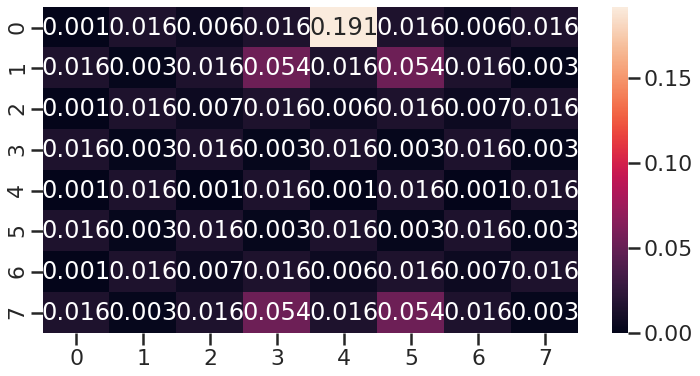

In [8]:
plot_mat = lambda mat:sns.heatmap(mat, annot=True, fmt="0.3f", vmin=0) # Function to plot a matrix as an image.

plt.figure(figsize=(12,6))

oracle = [4] # Marked elements
print([(i%8,i//8) for i in oracle]) 

res = simul_matrix_opt(3,oracle) # Make the simulation ...
plot_mat(res) # ... and plot it.
print(sum([res[i//8,i%8] for i in oracle]))

This second function do the same job, but instead of giving the probabilities at the last step, it  shows the probabilities of success at each step.

In [9]:
def simul_proba_opt(nb,search,m=-1):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output : {1},{2}
        [1} -> The list of the steps for which we make a measurement.
        {2} -> The probability of success for each step between 0 and m included.
    """
    global U_save
    N = 2**nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    p=[]
    M=[]
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    M.append(0)
    res = get_proba(psi)
    p.append(sum([res[i//N,i%N] for i in search]))
    
    for i in range(1,m+1):
        M.append(i)
        psi = np.dot(U,psi)
        res = get_proba(psi)
        p.append(sum([res[i//N,i%N] for i in search]))
    return M,p

[(4, 0)]


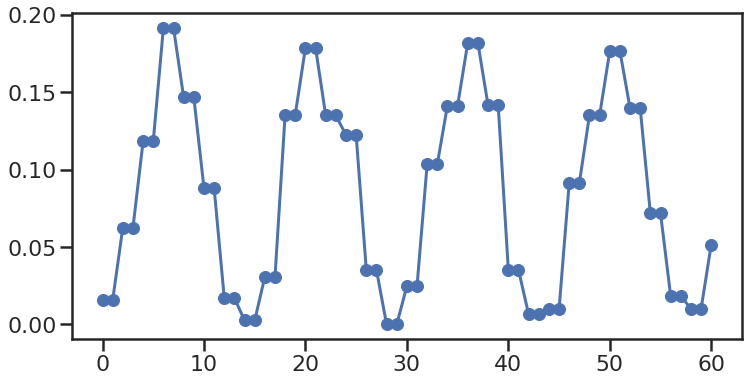

In [10]:
oracle = [4] # Marked elements
print([(i%8,i//8) for i in oracle]) 

m,p = simul_proba_opt(3,oracle,60)

plt.figure(figsize=(12,6))
plt.plot(m,p,'o-')

## 2. Different configurations of marked elements and eigenvalues
We look at the argument $\lambda$ of the eigenvalue of $U$ such that $\lambda$ is the argument closest to $0$ but $\lambda > 0$.

We also look at the fitted value $\tilde{\lambda}$ obtained by fitting $a\sin(\tilde{\lambda}t+b)$ for the signal.

In [11]:
def get_eigen(U):
    """
    Entry :
        U -> An operator.
    Output :
        The eigenvalue's argument lambda as defined in the paper.
    """
    norm = lambda x:np.sqrt(sum([abs(i)**2 for i in x]))
    val,vec = np.linalg.eig(U)
    l = [[np.angle(val[i]),vec[:,i]/norm(vec[:,i])] for i in range(len(val))]
    lbd = min([i for i in l if i[0]>1e-10],key=lambda x:x[0])
    return lbd[0]

In [12]:
def plot_walk(nb,search,path):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        path -> The path of the file for the figure.
    Output :
        The function don't output anything but plot a figure of the signal of the walk. 
        This figure is printed here and saved according to the path specified.
        The searched elements, lambda and fitted value of lambda are displayed.
    """
    global U_save
    N=2**nb
    
    x,y = simul_proba_opt(nb,search,50) # Get the signal
    
    # We compute the search operator for finding the value of lambda
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    lbd = get_eigen(U) # Get lambda

    plt.figure(figsize=(12,8))
    plt.plot(x[::],y[::],'o--',label="search")

    t = np.linspace(x[0],x[-1],1000)
    
    # Model using lambda
    model = lambda t,a,b:a*np.sin(lbd*t+b)**2
    param = curve_fit(model,x,y)[0]
    f = lambda t:model(t,*param)
    plt.plot(t,f(t),label="predicted frequency")
    
    # Model where even the period (value of lambda) is fitted
    model = lambda t,a,b,lbd:a*np.sin(lbd*t+b)**2
    param = curve_fit(model,x[::],y[::],p0=[*param,0.2])[0]
    print(param)
    f = lambda t:model(t,*param)
    plt.plot(t,f(t),label="fit")
    
    print("seached elements : {}\nlbd : {}\nfit : {}".format(search,lbd,param[-1]))

    #plt.xscale("log")
    #plt.yscale("log")

    plt.xlabel("steps")
    plt.ylabel("probability of success")
    plt.legend()
    plt.savefig("img/{}.svg".format(path))

We now can display some signals to check that there is a problem with the period $\lambda$ in some cases.

[0.17386509 0.09678818 0.21613759]
seached elements : [0]
lbd : 0.2157298010766718
fit : 0.21613758927937532


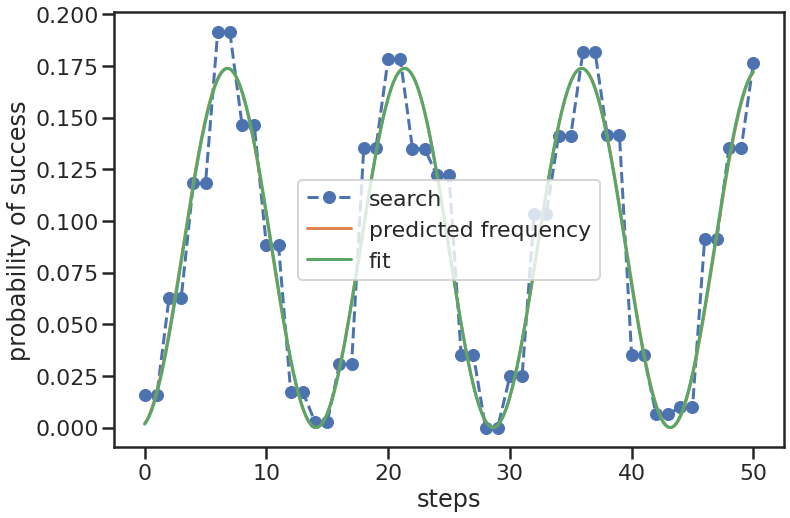

In [13]:
plot_walk(3,[0],"walk/aggreg1_proba")

[0.34773018 0.09678818 0.21613759]
seached elements : [0, 1]
lbd : 0.21572980107667222
fit : 0.2161375892216086


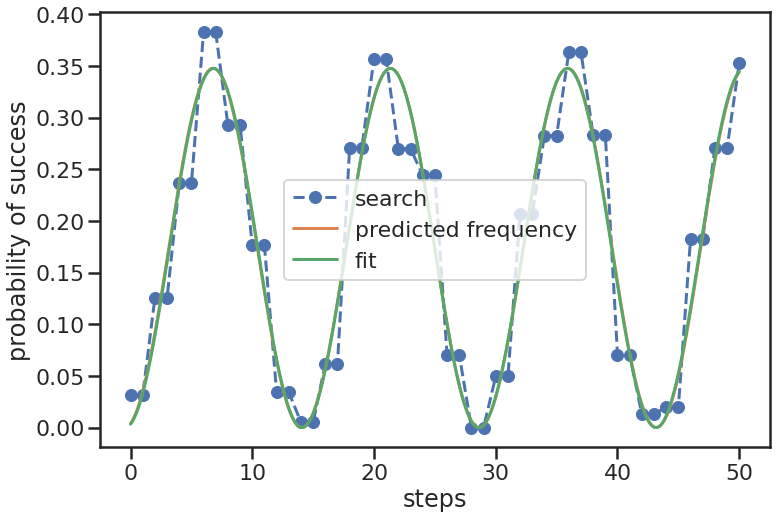

In [14]:
plot_walk(3,[0,1],"walk/aggreg2_proba")

[0.19526367 0.14125615 0.16738471]
seached elements : [0, 2]
lbd : 0.3364987090367755
fit : 0.16738470909759384


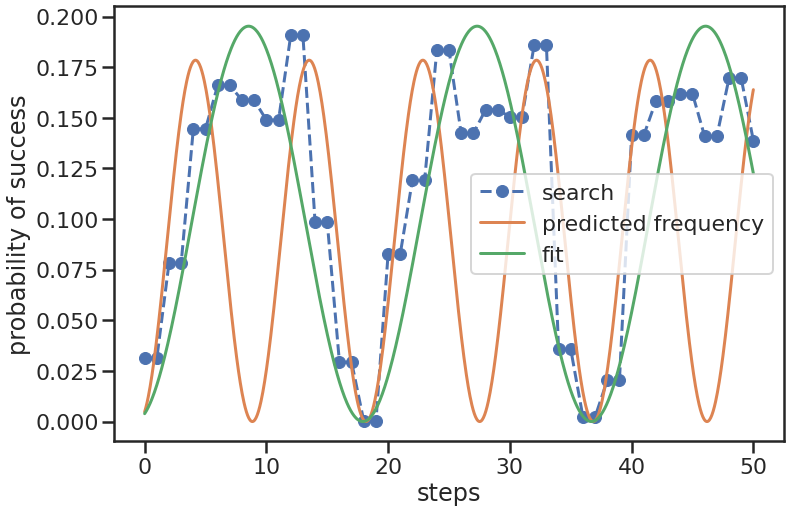

In [15]:
plot_walk(3,[0,2],"walk/interf1_proba")

[0.08185862 0.74215886 0.2216284 ]
seached elements : [0, 2, 4, 6]
lbd : 0.32433223627875496
fit : 0.22162840444346274


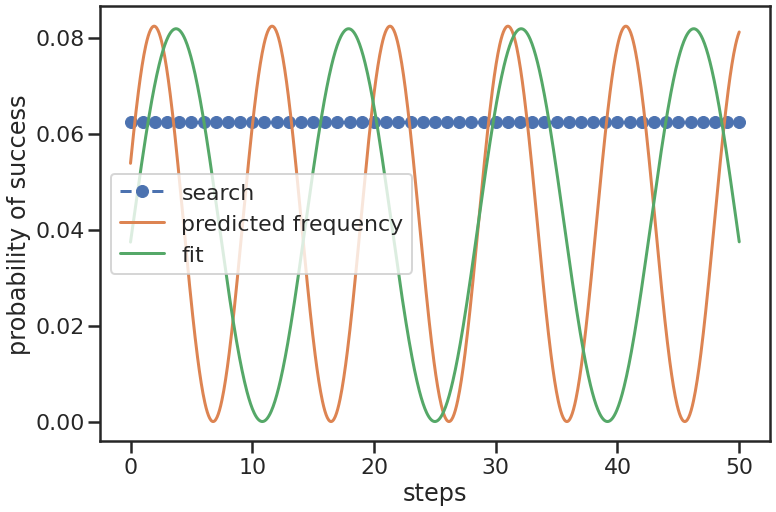

In [16]:
plot_walk(3,[0,2,4,6],"walk/interf2_proba")

[0.18681185 0.21956345 0.20366691]
seached elements : [0, 9]
lbd : 0.10306490444179153
fit : 0.2036669056670588


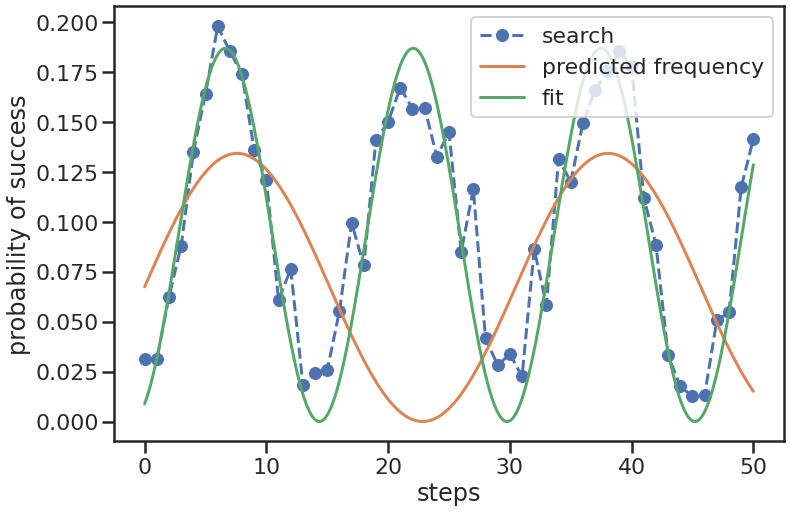

In [17]:
plot_walk(3,[0,9],"walk/mixed1_proba")

[0.17437367 0.24412244 0.16730836]
seached elements : [0, 18]
lbd : 0.05269802305609758
fit : 0.16730835695888405


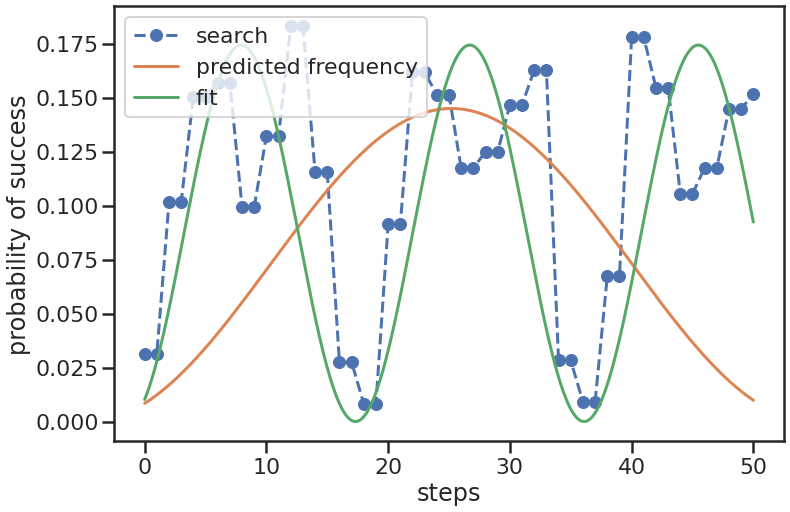

In [18]:
plot_walk(3,[0,18],"walk/mixed2_proba")

## 3. Statistics

The idea here is to check what  happens to the search performances in average over the marked elements configurations.

To do so, we save the results of several simulations with a configuration of marked element draw randomly uniformly.

Those results are saved in the panda dataframe data. The function used to compute the data used for the statistics in the article is included here. However, you can also load the data via pickle instead of computing them again since it's time consuming.

In [19]:
data = pd.DataFrame()
data["N"]=[]
data["nb_defect"] = []
data["search"] = []
data["success_proba"] = []
data["lbd"] = []
data["winner"] = []

Execute the block below if you want to load the data from the article.

In [20]:
data = pickle.load(open("data/data.pkl", "rb"))
data

,N,nb_defect,search,success_proba,lbd,winner
0,4.0,1.0,[6],0.250000,0.523599,1.0
0,4.0,1.0,[1],0.250000,0.523599,1.0
0,4.0,1.0,[0],0.250000,0.523599,1.0
0,4.0,1.0,[14],0.250000,0.523599,1.0
0,4.0,1.0,[2],0.250000,0.523599,1.0
...,...,...,...,...,...,...
0,8.0,63.0,"[25, 10, 26, 43, 15, 58, 6, 17, 48, 31, 19, 29...",0.808594,0.215730,1.0
0,8.0,63.0,"[13, 47, 33, 41, 49, 42, 36, 21, 11, 0, 51, 58...",0.808594,0.215730,1.0
0,8.0,63.0,"[39, 46, 34, 52, 54, 24, 22, 3, 48, 42, 25, 1,...",0.808594,0.215730,1.0
0,8.0,63.0,"[53, 49, 54, 38, 50, 45, 3, 25, 40, 30, 13, 63...",0.808594,0.215730,1.0


The function below add some simulations to the dataset. You can specify the size of the grid as well as the number of repetition for each number of marked elements. 

In [21]:
def add_simulation_to_data(nb,num_iter=100):
    """
    Entries :
        nb -> Size parameter for the grid.
        num_iter -> Number of repetitions.
    Output :
        There is no output but the dataframe data will get new entries. 
        For each number of marked elements between 1 and N^2-1, num_iter simulations will be performed and their content added to data.
        Each of the simulation draw a new configuration of marked elements.
    """
    global data
    N=2**nb

    search_range = list(range((2**nb)**2))
    search = np.random.choice(search_range,size=1,replace=False) # Draw one marked element
    res = simul_matrix_opt(nb,search)
    p = sum([res[i//(2**nb),i%(2**nb)] for i in search]) # This is the probability of success for one marked element.
    print("Proba of success for one marked element : ",p)
    
    # Beginning the simulations ...
    for num_defect in range(1,N*N):
        for i in range(num_iter):
            print("\r{} defects : {}%   ".format(num_defect,int(i*100/num_iter)),end="")
            
            search_range = list(range((2**nb)**2))
            search = np.random.choice(search_range,size=num_defect,replace=False) # Draw the configuration
            res = simul_matrix_opt(nb,search) # Make the simulation
            p1 = sum([res[i//(2**nb),i%(2**nb)] for i in search]) # Get the probability of success

            
            R = np.eye(N*N,dtype=complex)
            for i in search:
                R[i,i] = -1
            U_R = np.kron(np.eye(2),R)
            mat2 = np.dot(U_save[nb-1],U_R)
            lbd_ = get_eigen(mat2) # Get the eigenvalue lambda
            
            tmp = pd.DataFrame({"N":[2**nb],"nb_defect":[num_defect],"search":[search],"success_proba":[p1],"lbd":[lbd_],"winner":int(p1+1e-5>=p)})
            data=data.append(tmp) # Add to the dataset.
        print("\r{} defects : {}%   ".format(num_defect,100),end="")
    print("\ndone")

In [22]:
if False: # Turn it True if you want to compute the dataset again. You can also choose to add some data to the existing dataset using the same template.
    np.random.seed(42)
    print("4x4 grid")
    add_simulation_to_data(2,num_iter=1000)
    print("8x8 grid")
    add_simulation_to_data(3,num_iter=1000)

We consider some values $X = \{x_1,\ldots,x_n\}$.

The confidence interval is defined like this.
$$ 1.96\frac{\sigma(X)}{\sqrt{n}} $$

In [23]:
def confidence_interval(x):
    """
    Entry :
        x -> A list of values
    Output :
        the confidence interval according to the explainations above.
    """
    n = len(x)
    xm = np.mean(x)
    c = 1.96
    sig = np.sqrt(sum([(x[i]-xm)**2 for i in range(n)])/(n-1))
    return c*sig/np.sqrt(n)

Now, we can start to plot the average probability of success

In [24]:
def f(data1):
    """
    Take the mean of the success probability for each number of marked elements.
    """
    x = []
    for j in list(set(data1["nb_defect"])):
        if j > 1:
            tmp = list(data1[data1.nb_defect==j]["success_proba"])
            x.append([j,np.mean(tmp),confidence_interval(tmp)])
    x = np.array(x)
    return x

data1 = data[data.N==4]
data2 = data[data.N==8]

y=f(data2)

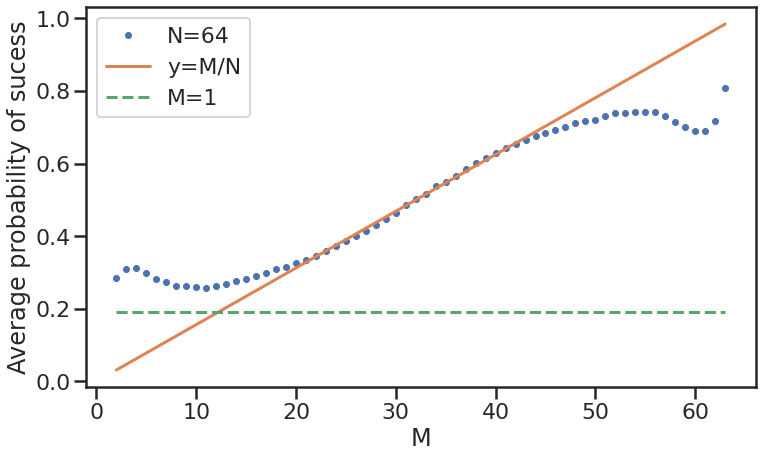

In [25]:
plt.figure(figsize=(12,7))

z = y

plt.plot(z[:,0],z[:,1],'.',label="N=64")
plt.plot(z[:,0],z[:,0]/64,label="y=M/N")
plt.plot(z[:,0],[0.19]*len(z[:,0]),'--',label="M=1")

plt.xlabel("M")
plt.ylabel("Average probability of sucess")

plt.legend()
plt.savefig("img/avg_proba.svg")

We can also plot the proportion of winning configurations (namely the configurations that perform better than the one with one marked element).

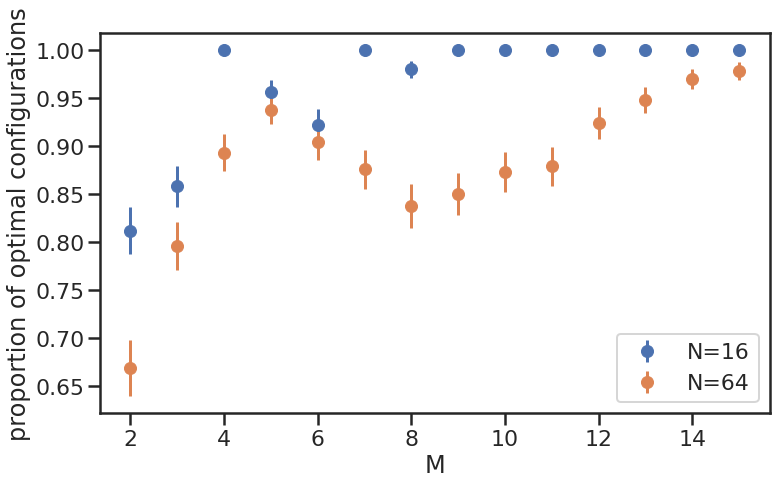

In [26]:
def f(data1):
    """
    Take the proportion of winning configuration and plot it.
    """
    x = []
    for j in list(set(data1["nb_defect"])):
        if 16 > j > 1:
            tmp = list(data1[data1.nb_defect==j]["winner"])
            x.append([j,np.mean(tmp),confidence_interval(tmp)])
    x = np.array(x)
    return x

data1 = data[data.N==4]
data2 = data[data.N==8]

plt.figure(figsize=(12,7))

x = f(data1)
plt.errorbar(x[:,0],x[:,1],yerr=x[:,2],fmt='o',label="N=16")

y=f(data2)
plt.errorbar(y[:,0],y[:,1],yerr=y[:,2],fmt='o',label="N=64")

plt.legend()
plt.xlabel("M")
plt.ylabel("proportion of optimal configurations")
plt.savefig("img/QW2Dsearch_success_proportion.svg")

## 4. Complexity comparaison between QWSearch and classical randomized algorithms
We compare the two hitting times considering tau fixed.

The hitting time of the QW Search is
$$ T_{qw} = \lceil \frac{\pi}{4}\sqrt{\alpha N\ln(N)} + \alpha \ln(N) \rceil. $$

The hitting time of the classical randomized algorithm is 
$$ T_{classic} = \frac{\ln\left(\frac{1}{8\times 0.32 \ln(N)}\right)}{\ln(1-\tau)}. $$

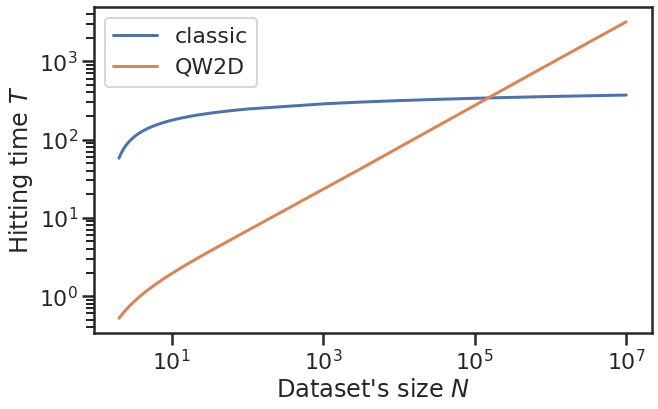

In [27]:
classic = lambda N,tau:np.log(1./(8*0.32*np.log(N)))/np.log(1.-tau) # Hitting time classic
qw = lambda N,tau:(math.pi/4.*0.32*np.sqrt(N*np.log(N)))+0.32*np.log(N) # Hitting time QWSearch

tau = 0.01
N = [2+i/100. for i in range(1,1000)]+list(np.linspace(12,100,1000))+list(range(100,10000000,1000))

plt.figure(figsize=(10,6))

plt.plot(N,[classic(i,tau) for i in N],label="classic")
plt.plot(N,[qw(i,tau) for i in N],label="QW2D")

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Dataset's size $N$")
plt.ylabel(r"Hitting time $T$")

plt.legend()

Now we try to plot the size N where the two hitting times are equal in function of $\tau$.

To do so we use a binary search approach.

In [28]:
def solve(f,a,b):
    """
    This is a binary search algorithm that solves the equation f(x)=0 over [a,b].
    Its requirements are :
        - f is continuous
        - f(x)=0 has exactly one solution over [a,b]
    """
    for i in range(1000):
        m = (a+b)/2.
        if f(m)*f(a)>0:
            a=m
        else:
            b=m
    return (a+b)/2.

The code below compute the data needed to plot the curve. This process isn't long.

In [29]:

f = lambda tau:(lambda N: classic(N,tau)-qw(N,tau)) # Difference between the two
    

x = [] # Values of tau
y = [] # Coresponding values of N such that the hitting times are equals
    
for k in range(20,6,-1): # Loop for very small values of tau
    t=2**(-k)
    r=solve(f(t), 2, 1e35) # Solving
    if abs(f(t)(r))<1e-5: # Check that binary search worked
        x.append(t)
        y.append(r)

tau = np.linspace(0,1,101) 
tau=tau[1:]
for t in tau :# Loop for relatively large values of tau.
    r=solve(f(t), 2.3, 1e35) # Solving
    if abs(f(t)(r))<1e-5: # Check that binary search worked
        x.append(t)
        y.append(r)
    else:
        x.append(t)
        y.append(0)
        break

And here is the plot.

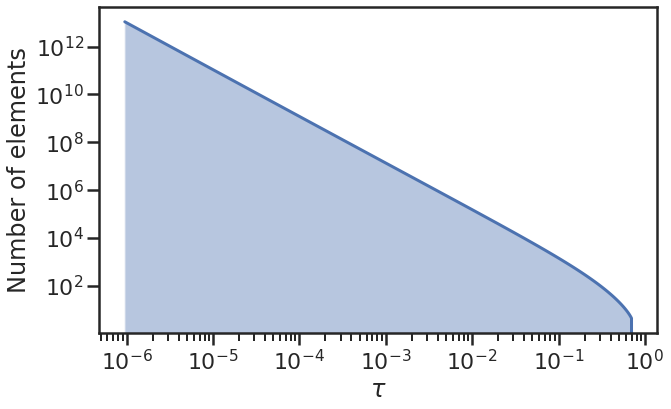

In [30]:
plt.figure(figsize=(10,6))


plt.plot(x,y)
plt.fill_between(x, y, alpha=0.4)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$\tau$")
plt.ylabel("Number of elements")

plt.savefig("img/tau_vs_N.png")